In [23]:
import gym
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import math, random
from typing import Tuple
import matplotlib.pyplot as plt
import time

In [24]:
env = gym.make('CartPole-v0')

In [25]:
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

In [26]:
#observation går fra 0-3
#0 cart position
#1 cart velocity
#2 pole angle
#3 pole velocity at tip

In [27]:
n_bins = (6,12)

#upper og lower bounds
upper_bounds = [env.observation_space.high[2], math.radians(30)]
lower_bounds = [env.observation_space.low[2], -math.radians(30)]
Q = np.zeros(n_bins + (n_actions,))

In [28]:
def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

In [29]:
def policy (state : tuple):
    return np.argmax(Q[state])

In [30]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    future_optimal_value = np.max(Q[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

In [31]:
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

def exploration_rate(n : int, min_rate=0.15 ) -> float :
    return max(min_rate, min(1.0, 1.0 - math.log10((n  + 1) / 25)))

In [32]:
epochs_all = []
n_episodes = 300 
for e in range(n_episodes):

    current_state, done = discretizer(*env.reset()), False
    epochs = 0
    
    while done==False:
        action = policy(current_state)
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample()
         
        obs, reward, done, _ = env.step(action)
        new_state = discretizer(*obs)
        
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q[current_state][action]
        Q[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state
        epochs += 1

        if(e>n_episodes-20):
            env.render()
    
    epochs_all.append(epochs)


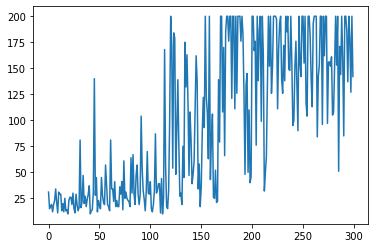

In [33]:
plt.plot(epochs_all, label='epochs')

In [34]:
env.close()